In [1]:
import configparser
config = configparser.ConfigParser()

config.read("../final_project_files/env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [2]:
OHCO = ['book_title', 'chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [3]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

import gensim
gensim.__version__

'4.3.2'

In [4]:
TOKENS = pd.read_csv(f"{output_dir}\\CORPUS.csv").set_index(OHCO)
VOCAB = pd.read_csv(f"{output_dir}\\BOW_chaps.csv").set_index('term_str')

In [5]:
VOCAB.sample(10)

n max_pos       dfidf  mean_tfidf
term_str                                        
giddiness      2      NN   18.248243    0.021828
59             6      CD   47.410373    0.056711
fosterlings    1     NNS    9.709084    0.011614
piety         12      NN   60.313270    0.089342
lumpish        1      NN    9.709084    0.011614
adjudicating   1     VBG    9.709084    0.011614
disengaging    1     VBG    9.709084    0.011614
fearing       26     VBG  150.216102    0.183889
responds       1     VBZ    9.709084    0.011614
gggodswood     1      NN    9.709084    0.011614

### Genshim

In [6]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(CHAPS)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [7]:
vocab = Dictionary(docs)

### Word Embeddings

In [8]:
model = word2vec.Word2Vec(docs, **w2v_params)
model.wv.vectors

array([[-0.16343684, -0.12825641,  0.05909265, ...,  1.0053921 ,
         0.443167  ,  0.7598857 ],
       [-0.03121548, -0.27325717,  0.21753402, ...,  0.26430643,
         0.59186816,  0.00258114],
       [ 0.4243017 , -0.5879543 ,  0.3080141 , ..., -0.16027701,
        -0.37212527, -0.23095825],
       ...,
       [-0.02738334, -0.15776621,  0.10276374, ..., -0.18721154,
         0.2477983 ,  0.00451072],
       [-0.21428144, -0.04484319,  0.23126248, ..., -0.2157318 ,
         0.16643457,  0.20616087],
       [-0.17273659, -0.07478475,  0.12051546, ..., -0.09769986,
         0.14431468,  0.2737575 ]], dtype=float32)

### Vis

In [9]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [10]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [11]:
WV

0         1         2         3         4         5    \
term_str                                                               
the      -0.163437 -0.128256  0.059093  0.004044 -0.110198 -0.250891   
and      -0.031215 -0.273257  0.217534  0.612432 -0.224710 -0.792811   
to        0.424302 -0.587954  0.308014 -0.187611  1.260691  0.965249   
a        -0.464171 -0.137561  1.439024 -0.291468  0.571978 -0.586647   
of        0.303545 -0.142118 -0.534985 -0.130450  0.387435 -0.427412   
...            ...       ...       ...       ...       ...       ...   
unseen   -0.056065 -0.010156 -0.037001  0.005442  0.149572 -0.031311   
carpet   -0.233539 -0.037085  0.163382  0.100223 -0.307659 -0.035916   
rail     -0.214281 -0.044843  0.231262 -0.131050 -0.068299 -0.074882   
brittle  -0.105830 -0.014783  0.057834  0.122076 -0.310575 -0.103712   
inclined -0.205397 -0.339850  0.355561  0.061931 -0.349880 -0.069876   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
the       0.389039  0.256540 -0.286446 -1.102226  ... -0.368064 -0.236609   
and      -0.424529 -0.163290 -0.548647 -0.673912  ... -0.013944  0.321863   
to        0.376830  0.717394 -0.056963  0.570712  ... -1.812758  0.220800   
a         0.621885 -0.761118 -1.236854 -0.254564  ... -0.375958 -0.363460   
of       -0.685568 -0.005584  1.018735  0.783749  ... -0.631194  0.695055   
...            ...       ...       ...       ...  ...       ...       ...   
unseen   -0.085480 -0.139386 -0.054818 -0.181677  ... -0.050961  0.129199   
carpet   -0.203895 -0.266285 -0.367900 -0.299048  ...  0.286121  0.089435   
rail     -0.213761 -0.366190 -0.454335 -0.394748  ...  0.231045  0.249592   
brittle  -0.072009 -0.009129 -0.074386 -0.148704  ... -0.046547  0.047402   
inclined -0.112227 -0.034926 -0.054998 -0.225181  ...  0.173648 -0.067108   

               238       239       240       241       242       243  \
term_str                                                               
the       0.086287 -0.059608 -0.324620 -0.362045 -0.287584  1.005392   
and       0.161918  0.339101 -0.026519 -0.602658  0.306286  0.264306   
to        0.118762  0.556284 -0.122308  0.332399  0.001264 -0.160277   
a         0.143828 -1.293837  0.929130  0.336258  0.303619  1.275978   
of       -0.715550 -0.362770 -0.053502  0.033372 -0.878049  0.556107   
...            ...       ...       ...       ...       ...       ...   
unseen    0.094677  0.095517 -0.006480 -0.102694  0.004945 -0.065837   
carpet    0.152292 -0.024484  0.290678  0.116934 -0.050131 -0.180491   
rail      0.057501  0.076584  0.241488 -0.034288 -0.078703 -0.215732   
brittle  -0.009257 -0.209219  0.002900 -0.000900  0.035900 -0.005281   
inclined -0.254675 -0.080339 -0.121453 -0.009570 -0.098316  0.169918   

               244       245  
term_str                      
the       0.443167  0.759886  
and       0.591868  0.002581  
to       -0.372125 -0.230958  
a        -0.189468 -0.123430  
of        0.255946  0.181406  
...            ...       ...  
unseen    0.095642  0.186070  
carpet    0.098445  0.035996  
rail      0.166435  0.206161  
brittle   0.038537  0.147259  
inclined  0.028777  0.027472  

[3573 rows x 246 columns]

In [12]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [13]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [14]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [15]:
TSNE

x          y
term_str                      
the      -13.364929  16.496008
and      -29.783697  -7.535274
to        37.044872  16.513453
a          5.188275  13.551836
of         9.121741  18.570864
...             ...        ...
unseen     7.714799   0.031920
carpet   -28.003548  -0.612764
rail     -23.586535  -6.028102
brittle   -3.914656  14.108339
inclined -20.804573 -32.171841

[3573 rows x 2 columns]

In [16]:
X = TSNE.join(VOCAB, how='left')

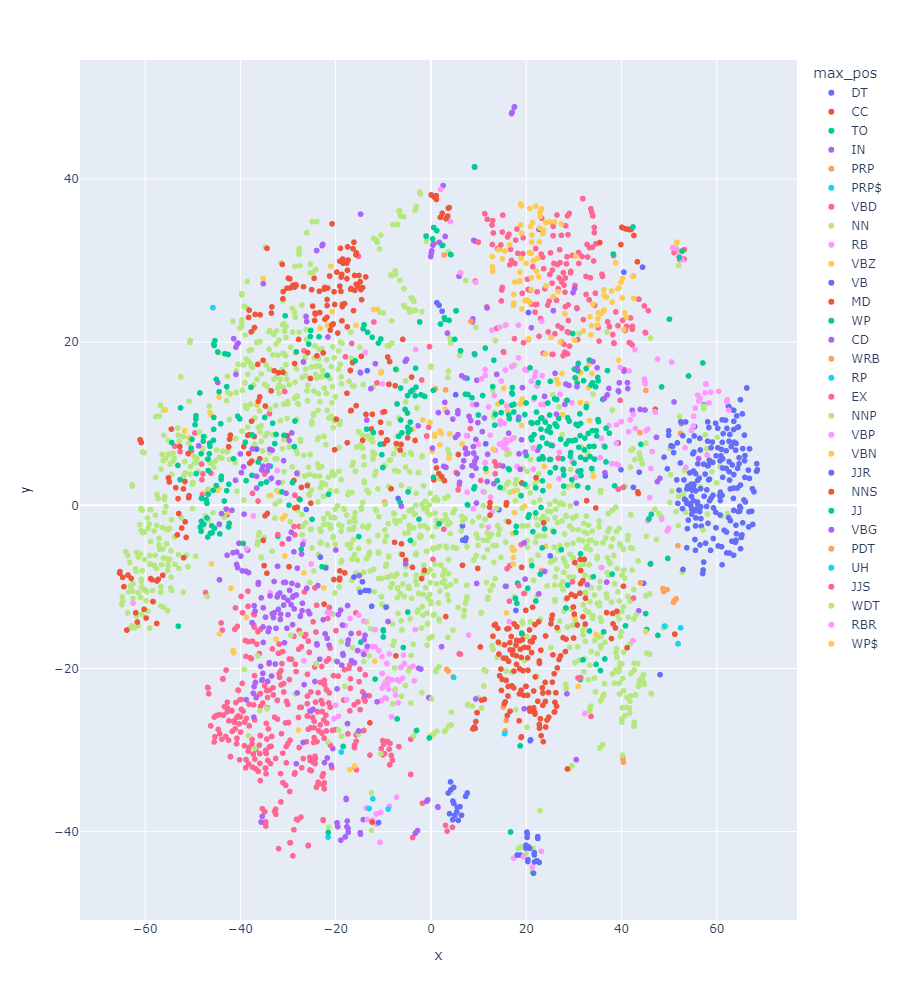

In [17]:
px.scatter(X.reset_index(), 'x', 'y', 
           # text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           # size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

### By Series...

In [18]:
LIB = pd.read_csv(f'{output_dir}\\LIB_LABELS.csv').set_index('book_title')

In [19]:
LIB.head(2)

book_length  n_chaps        series  year  \
book_title                                                       
01_a_game_of_thrones       297169       73        ASOIAF  1996   
01_into_the_wild            64386       26  Warrior_Cats  2003   

                                  author  \
book_title                                 
01_a_game_of_thrones  George R.R. Martin   
01_into_the_wild               Kate Cary   

                                                                label  \
book_title                                                              
01_a_game_of_thrones  George R.R. Martin: 01_a_game_of_thrones (1996)   
01_into_the_wild                   Kate Cary: 01_into_the_wild (2003)   

                      y_raw_3  y_L2_3  y_raw_4  y_L2_4  
book_title                                              
01_a_game_of_thrones        1       2        1       1  
01_into_the_wild            0       1        2       0

In [20]:
TOKENS.head(2)

token_str term_str  \
book_title           chap_num para_num sent_num token_num                      
01_a_game_of_thrones 1        0        1        1                We       we   
                                                2            should   should   

                                                           pos pos_group  
book_title           chap_num para_num sent_num token_num                 
01_a_game_of_thrones 1        0        1        1          PRP        PR  
                                                2           MD        MD

In [21]:
asoiaf = "|".join(list(LIB.query("series=='ASOIAF'").index))
cats = "|".join(list(LIB.query("series=='Warrior_Cats'").index))
dragons = "|".join(list(LIB.query("series=='Last_Dragon_Chronicles'").index))
dragons

'01_the_fire_within|02_icefire|03_the_fire_eternal|04_fire_star|05_dark_fire|06_fire_world|07_the_fire_ascending'

In [22]:
TOKENS_asoiaf = TOKENS.loc[LIB[LIB.label.str.contains(asoiaf)].index]
TOKENS_cats = TOKENS.loc[LIB[LIB.label.str.contains(cats)].index]
TOKENS_dragons = TOKENS.loc[LIB[LIB.label.str.contains(dragons)].index]
TOKENS_asoiaf

token_str term_str  \
book_title           chap_num para_num sent_num token_num                      
01_a_game_of_thrones 1        0        1        1                We       we   
                                                2            should   should   
                                                3             start    start   
                                                4              back     back   
                                                7             Gared    gared   
...                                                             ...      ...   
04_a_feast_for_crows 46       131      1        10             said     said   
                                                13             like     like   
                                                14              the      the   
                                                15              pig      pig   
                                                16              boy      boy   

                                                           pos pos_group  
book_title           chap_num para_num sent_num token_num                 
01_a_game_of_thrones 1        0        1        1          PRP        PR  
                                                2           MD        MD  
                                                3           VB        VB  
                                                4           RB        RB  
                                                7          NNP        NN  
...                                                        ...       ...  
04_a_feast_for_crows 46       131      1        10         VBD        VB  
                                                13          IN        IN  
                                                14          DT        DT  
                                                15          NN        NN  
                                                16          NN        NN  

[1344644 rows x 4 columns]

In [23]:
docs = TOKENS_asoiaf[~TOKENS_asoiaf.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(CHAPS)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]
vocab = Dictionary(docs)

model_asoiaf = word2vec.Word2Vec(docs, **w2v_params)
model_asoiaf.wv.vectors

array([[ 0.05857556,  0.06405023,  0.20187669, ..., -0.10326077,
        -0.01423591,  0.42374894],
       [-0.47811905, -0.260341  , -0.10373608, ..., -0.0492686 ,
         0.10300158, -0.24593575],
       [ 0.56441504, -0.21301946, -0.04329185, ..., -0.10843469,
        -0.42871067,  0.04715348],
       ...,
       [-0.2674842 ,  0.03239943,  0.02847896, ...,  0.04818184,
         0.01491352,  0.09855369],
       [ 0.05241085, -0.14269605, -0.05757073, ...,  0.10284666,
         0.01562093, -0.09625293],
       [-0.0156049 , -0.01450686, -0.00233592, ...,  0.05061883,
        -0.07171628, -0.04266082]], dtype=float32)

In [24]:
WV_asoiaf = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
tsne_model = tsne_engine.fit_transform(WV_asoiaf.to_numpy())
TSNE_asoiaf = pd.DataFrame(tsne_model, columns=['x','y'], index=WV_asoiaf.index)
X_asoiaf = TSNE_asoiaf.join(VOCAB, how='left')

In [25]:
px.scatter(X_asoiaf.reset_index(), 'x', 'y', 
           # text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [26]:
docs = TOKENS_cats[~TOKENS_cats.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(CHAPS)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]
vocab = Dictionary(docs)

model_cats = word2vec.Word2Vec(docs, **w2v_params)
model_cats.wv.vectors

array([[-0.32716945, -0.59488094,  0.327445  , ..., -0.06707988,
         0.35069156,  0.16787028],
       [ 0.16982391,  0.20071231, -0.27334085, ..., -0.4995738 ,
         0.07299901, -0.15818007],
       [ 0.09444708,  0.02334705,  0.0895137 , ..., -0.33139426,
        -0.29278362, -0.07036997],
       ...,
       [ 0.04050638, -0.09165987,  0.01102066, ...,  0.03448612,
        -0.06098986, -0.01210439],
       [-0.01200483, -0.11380564, -0.04253595, ...,  0.0395791 ,
         0.18665679,  0.15782024],
       [ 0.04791322, -0.09359335, -0.04482153, ..., -0.06038397,
         0.02928926, -0.01333428]], dtype=float32)

In [27]:
WV_cats = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
tsne_model = tsne_engine.fit_transform(WV_cats.to_numpy())
TSNE_cats = pd.DataFrame(tsne_model, columns=['x','y'], index=WV_cats.index)
X_cats = TSNE_cats.join(VOCAB, how='left')

In [28]:
px.scatter(X_cats.reset_index(), 'x', 'y', 
           # text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [29]:
docs = TOKENS_dragons[~TOKENS_dragons.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(CHAPS)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]
vocab = Dictionary(docs)

model_dragons = word2vec.Word2Vec(docs, **w2v_params)
model_dragons.wv.vectors

array([[ 0.09701761, -0.13996841, -0.08331692, ...,  0.22984351,
         0.09562313, -0.01501857],
       [ 0.15570912,  0.00299592, -0.24947895, ..., -0.0897297 ,
         0.26243022, -0.25402948],
       [ 0.2401022 , -0.15348332, -0.21055712, ..., -0.09316145,
         0.14433978,  0.26447323],
       ...,
       [ 0.04976709, -0.07004241, -0.04260381, ..., -0.03302112,
         0.12558143,  0.07199457],
       [ 0.04207691, -0.17125289, -0.02909497, ..., -0.0003488 ,
         0.10069583,  0.07062919],
       [ 0.03889939, -0.17032535,  0.00774298, ..., -0.02742486,
         0.11392281,  0.04996561]], dtype=float32)

In [30]:
WV_dragons = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
tsne_model = tsne_engine.fit_transform(WV_dragons.to_numpy())
TSNE_dragons = pd.DataFrame(tsne_model, columns=['x','y'], index=WV_dragons.index)
X_dragons = TSNE_dragons.join(VOCAB, how='left')

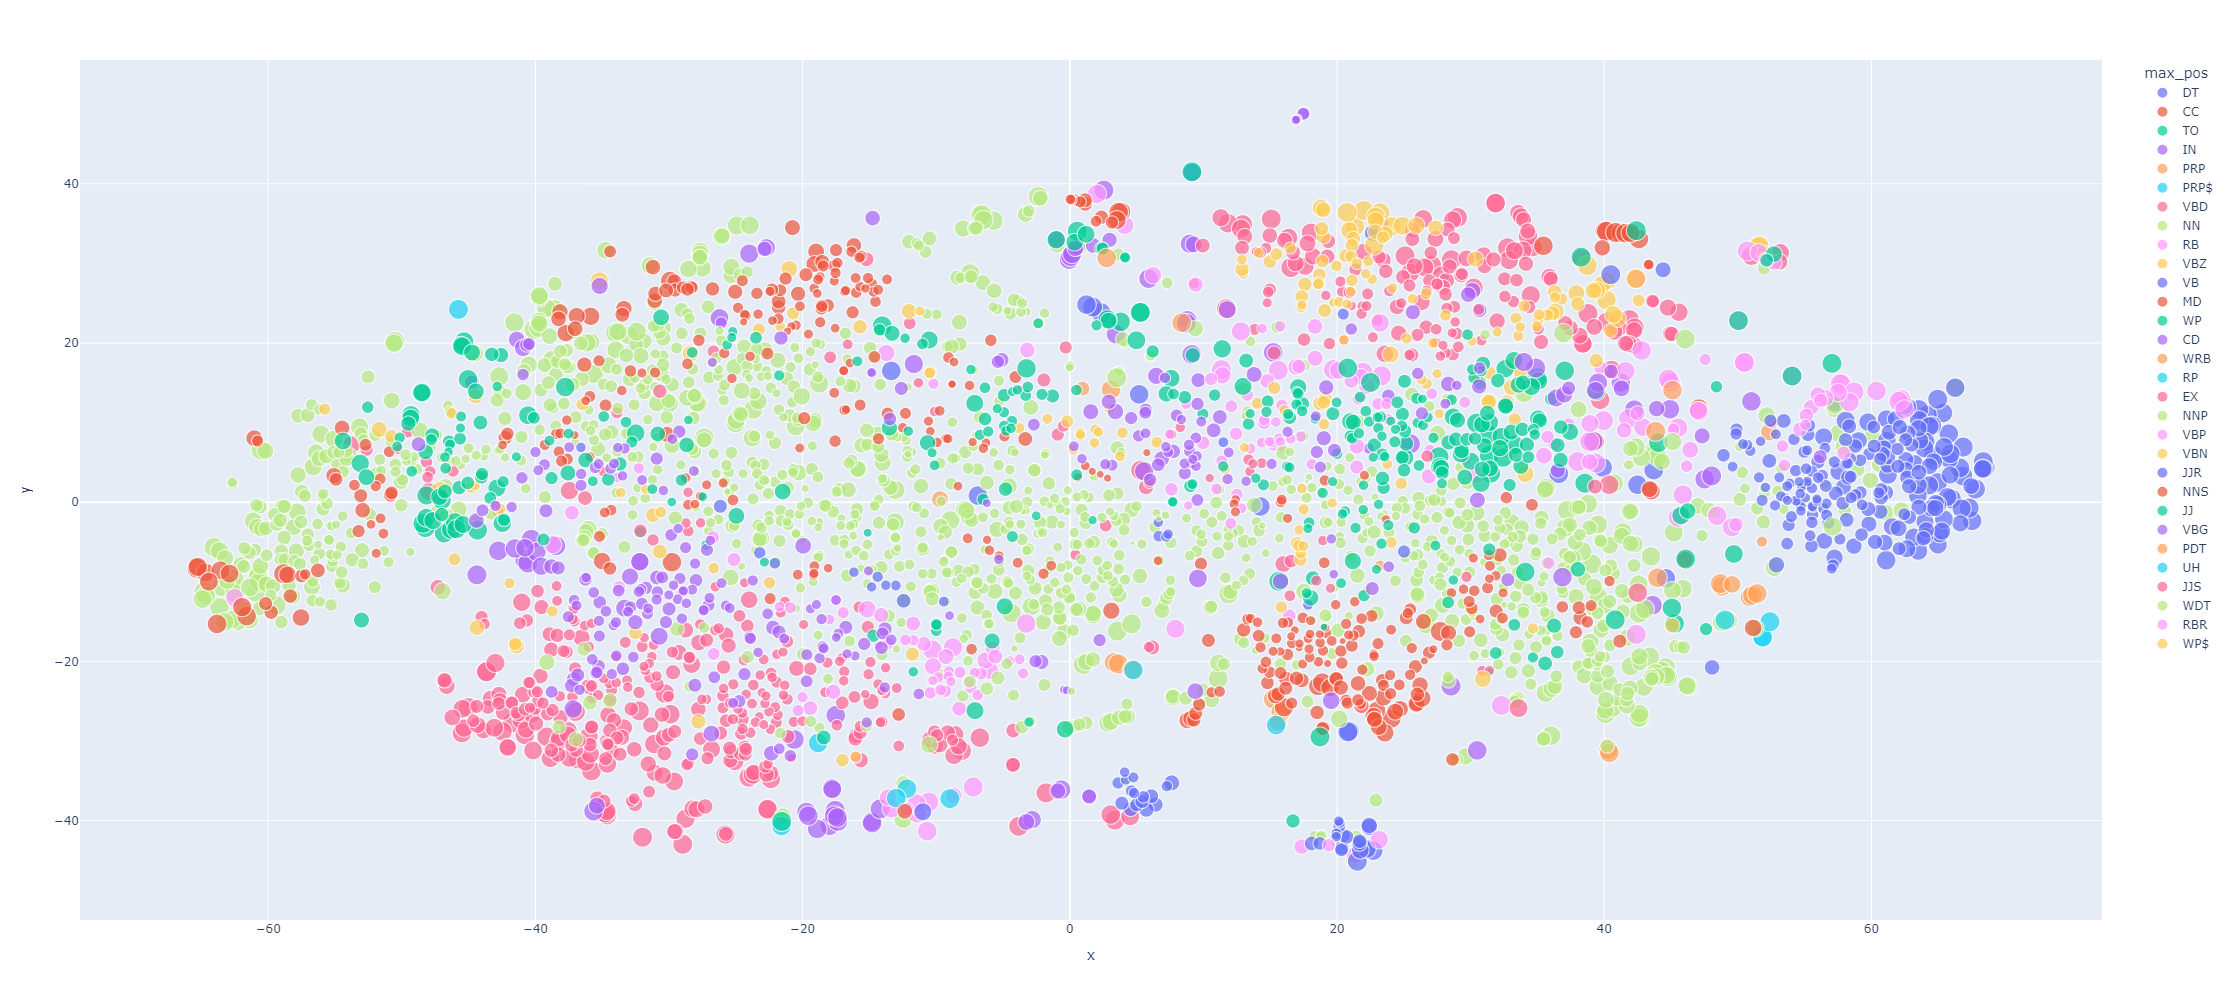

In [31]:
px.scatter(X_dragons.reset_index(), 'x', 'y', 
           # text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')